In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 4: LCMS Model Training Data Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/4-Training_Data_Setup.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/4-Training_Data_Setup.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/4-Training_Data_Setup.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes reference data from the TimeSync image interpretation tool and extracts the values from the LandTrendr and CCDC outputs from the previous notebooks as well as elevation data to create the training data tables needed for LCMS model calibration


### Objective

In this tutorial, you learn how to create model training featureCollections in GEE using methods that are unlikely to run out of memory

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in TimeSync data
- Creating terrain predictors
- Extracting LandTrendr, CCDC, and terrain values for TimeSync plot locations as assets

## Before you begin

### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/newFolder`
* This folder does not have to already exist. If it does not exist, it will be created

**If you are working in Qwiklabs and wish to export:** Copy the project ID from the 'Start Lab' screen into the `projectID` field in `export_path_root`.

In [1]:
workbench_url = 'https://7c39a91cfd2f6ff9-dot-us-central1.notebooks.googleusercontent.com/'
pre_baked_path_root  = 'projects/rcr-gee/assets/lcms-training'
export_path_root = pre_baked_path_root
#export_path_root = 'projects/projectID/assets/newFolder'
print('Done')


Done


# Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.


In [7]:
#Module imports
!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p

ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Done


## Set up your work environment

Create a folder in your export path where you will export the composites. In addition, create a blank image collection where your composites will live.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [8]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_composite_collection = f'{export_path_root}/lcms-training_module-2_composites'
export_landTrendr_collection = f'{export_path_root}/lcms-training_module-3_landTrendr'
export_ccdc_collection = f'{export_path_root}/lcms-training_module-3_CCDC'

# This is a new folder for this module
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/rcr-gee/assets/training-materials/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC_wStrata'


aml.create_asset(export_timeSync_folder)

# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Found the following sub directories:  ['lcms-training', 'lcms-training_module-4_timeSync']
Will attempt to create them if they do not exist
projects/rcr-gee/assets/lcms-training
Could not create:  projects/rcr-gee/assets/lcms-training
Permission 'earthengine.assets.create' denied on resource 'projects/rcr-gee' (or it may not exist).
Asset projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync already exists
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Could not update permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Asset 'projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync' does not exist or doesn't allow this operation.
Done


In [9]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1231
Map.proxy_url = workbench_url

print('Done')

Done


**TimeSync Data Introduction**
* We will first:
    * Set some projection info
    * Bring in the TimeSync training data for our study area 
    * And take a look at some info about the TimeSync data

In [10]:
# First, let's bring in TimeSync and set up some parameters
# Set the projection
# Even though we're working outside the Conterminous United States, Puerto Rico and the US Virgin Islands
# uses the same USGS Albers projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None

# Bring in annualized TimeSync data
# Each plot has one feature for each year from 2000 to 2020
# This results in over 20k plots
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
training_year_hist = timeSyncData.aggregate_histogram('YEAR').getInfo()
training_years = [int(yr) for yr in list(training_year_hist.keys())]
plot_ids = timeSyncData.aggregate_histogram('PLOTID').keys().getInfo()
print('Training years:',training_years)
print('Unique Plot ID Count:',len(plot_ids))
print('Total Training Plots:', timeSyncData.size().getInfo())
print('TimeSync Attributes:',timeSyncData.first().propertyNames().getInfo())

print('Done')

Training years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Unique Plot ID Count: 1000
Total Training Plots: 20992
TimeSync Attributes: ['STRATUM_PIXEL_COUNT', 'DOM_LU', 'STRATUM', 'GRASS-TS', 'STRATUM_WEIGHT', 'latitude', 'JULIANDAY', 'COMMENTS', 'BARREN-IMP', 'SEC_LC', 'SHRUBS-TRE', 'STRATUM_AREA', 'INTERP', 'YEAR', 'SHRUBS', 'STRATUM_SAMPLE_COUNT', 'X', 'GRASS', 'Y', 'SEC_LU', 'SEC_LU_EL', 'DOM_SEC_LC', 'BARREN-GRA', 'DOM_LU_EL', 'IMPERVIOUS', 'WATER', 'longitude', 'CP_NOTES', 'SNOW', 'STRATUM_PIXEL_PCT', 'BARREN-TS', 'GRASS-TREE', 'PLOTID', 'CP', 'LAST_MODIF', 'BARREN-TRE', 'GRASS-SHRU', 'PACKET_ID', 'BARREN', 'DOM_LC', 'TREES', 'BARREN-SHR', 'CHANGE_DUR', 'SHRUBS-TS', 'STRATUM_SAMPLE_PCT', 'system:index', 'TS-TREES', 'TS']
Done


* Notice the years extend from 2000-2020 despite our mapping period extending from 1985 till 2022
* This is because there was insufficient Landsat imagery before 1999 (Landsat 7) over Puerto Rico and the US Virgin Islands
* Therefore we limited the training data collection period to 2000-2020
* Next, we will look at how the number of plots varies for each year

<Axes: title={'center': 'PRUSVI Training Data Counts Per Year'}, xlabel='Year', ylabel='Plot Count'>

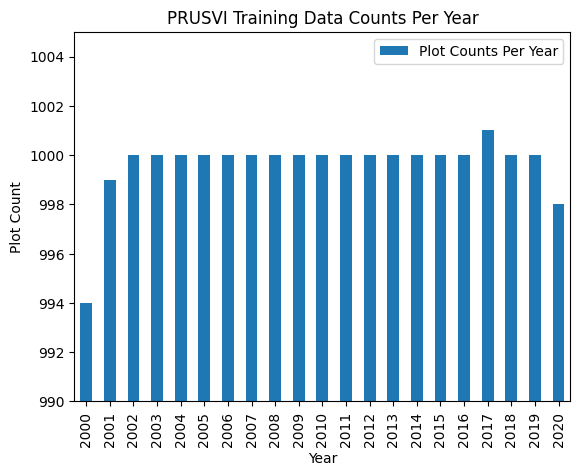

In [6]:
# Look at the number of plots per year
training_year_hist_df = g2p.pandas.DataFrame(training_year_hist.values(),columns = ['Plot Counts Per Year'],index =training_year_hist.keys() )
training_year_hist_df.plot.bar(ylim = (990,1005),xlabel='Year',ylabel='Plot Count', title = 'PRUSVI Training Data Counts Per Year')

* Notice the early and late years do not quite have the full 1000 plots
* This is becuase analysts need sufficient imagery to make a solid call at the beginning and end of the time series above all else
* They must only provide a response when there are sufficient data to do so

* Next, we will look at a single plot location on the map

In [11]:
Map.clearMap()

# Let's view the TimeSync data
# This will zoom to the first plot in the featureCollection
# Find a plot (they're 30m x 30m - small), and double-click on it to see 
# that there are actually multiple plots at that location - 1 for each year
Map.addLayer(timeSyncData.map(lambda f:f.buffer(15).bounds(5,crs)),{'layerType':'geeVectorImage'},'LCMS PRUSVI TimeSync Training Data')
Map.turnOnInspector()
Map.centerObject(timeSyncData.first())
Map.view()

Adding layer: LCMS PRUSVI TimeSync Training Data
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Starting local web server at: http://localhost:1231/geeView/
HTTP server command: "/opt/conda/bin/python" -m http.server  1231
Done
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://7c39a91cfd2f6ff9-dot-us-central1.notebooks.googleusercontent.com/proxy/1231/geeView/?accessToken=None


127.0.0.1 - - [05/Sep/2023 20:44:40] "GET /geeView/?accessToken=None HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:40] "GET /geeView/css/style.min.css HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:40] "GET /geeView/js/gena-gee-palettes.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:40] "GET /geeView/js/load.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:40] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:40] "GET /geeView/js/lcms-viewer.min.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:41] "GET /geeView/images/logos_usda-fs.svg HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:41] "GET /geeView/images/layer_icon.png HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:41] "GET /geeView/images/GEE.png HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:41] "GET /geeView/images/usfslogo.png HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:41] "GET /geeView/images/GEE_logo_transparent.png HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:44:41]

* Notice that there are many individual plots (1 for each year) within this single plot location
* This is how the time series of training data are represented - 1 plot for each year for a given plot location

* The challenge is we have to pull all relevant predictor variables for each year from LandTrendr and CCDC without running out of memory
* If we pulled the predictors, trained a model, and applied it all at once, chances are very high we would run out of memory and it would fail
* In order to reduce the possibility of memory errors, we will extract predictors from our TimeSync plot locations for each year and export them individually as a featureCollection asset


### We will now set up annual LandTrendr and CCDC outputs from our raw exported assets

* First, we will annualize our LandTrendr outputs
* While the fitted LandTrendr values are the most important, recall from module 3.1 that there are additional pieces of information we can take from LandTrendr:
![workspace url](https://emapr.github.io/LT-GEE/imgs/segment_attributes.png)
* Double-clicking on the map after running the code below, you'll notice there are band names that end with mag, slope, diff, dur, and fitted for each index/band


In [12]:

# First, we will bring in LandTrendr data for each year
landTrendrCollection = ee.ImageCollection(export_landTrendr_collection)

landTrendrCollectionInfo = landTrendrCollection.first().toDictionary().getInfo()

Map.clearMap()

# View exported LT output
# Convert stacked outputs into collection of fitted, magnitude, slope, duration, etc values for each year
# While the fitted LandTrendr value is generally of most importance to our models, 
# LandTrendr segment duration, slope, and magnitude of change can also help our models
lt_fit = changeDetectionLib.batchSimpleLTFit(landTrendrCollection,landTrendrCollectionInfo['startYear'],landTrendrCollectionInfo['endYear'],None,bandPropertyName='band',arrayMode=True)

# Vizualize image collection for charting (opacity set to 0 so it will chart but not be visible)
Map.addLayer(lt_fit,{'bands':'swir2_LT_fitted,nir_LT_fitted,red_LT_fitted','min':0.15,'max':0.6},'LandTrendr All Predictors Time Series')

# Visualize fitted landTrendr composites
fitted_bns = lt_fit.select(['.*_fitted']).first().bandNames()
out_bns = fitted_bns.map(lambda bn: ee.String(bn).split('_').get(0))

# Give same names as composites
lt_synth = lt_fit.select(fitted_bns,out_bns)

# Visualize LandTrendr fitted 
Map.addTimeLapse(lt_synth,getImagesLib.vizParamsFalse,'Fitted LandTrendr Composite Timelapse')

# add timesync data 
Map.addLayer(timeSyncData.map(lambda f:f.buffer(15).bounds(5,crs)),{'layerType':'geeVectorImage'},'LCMS PRUSVI TimeSync Training Data')
Map.centerObject(timeSyncData.first())
Map.turnOnInspector()
Map.view()

Adding layer: LandTrendr All Predictors Time Series
Adding layer: Fitted LandTrendr Composite Timelapse
Adding layer: LCMS PRUSVI TimeSync Training Data
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1231/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://7c39a91cfd2f6ff9-dot-us-central1.notebooks.googleusercontent.com/proxy/1231/geeView/?accessToken=None


127.0.0.1 - - [05/Sep/2023 20:45:31] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 20:45:37] "GET /geeView/images/cumulative_icon.png HTTP/1.1" 200 -


* Next, we will annualize our raw CCDC output
* We allow for the use of the date of each pixel for each year from the composite collection to be used for annualizing CCDC
* This helps ensure both LandTrendr and CCDC values reflect data from a similar date within each year
* We also use a method to annualize that not only finds the harmonic model for each year, and the fitted values, but also computes the difference of fitted values from a given year and the previous year (e.g. year 2000 would have the difference between the year 2000 and 1999 fitted values) included as well with the band name ending "fitSlope"

In [13]:
# And then bring in CCDC data for each year
Map.clearMap()

# Bring in the tiled CCDC asset
ccdcTiles = ee.ImageCollection(export_ccdc_collection)
ccdcImg = ccdcTiles.mosaic()

# Bring in the composites to pull the composite observation date for annualizing CCDC
composites = ee.ImageCollection(export_composite_collection)

# Set up some date parameters
startYear = 1984
endYear = 2023
startJulian = 1
endJulian = 365


#Specify which harmonics to use when predicting the CCDC model
#CCDC exports the first 3 harmonics (1 cycle/yr, 2 cycles/yr, and 3 cycles/yr)
#If you only want to see yearly patterns, specify [1]
#If you would like a tighter fit in the predicted value, include the second or third harmonic as well [1,2,3]
whichHarmonics = [1,2,3]

#Whether to fill gaps between segments' end year and the subsequent start year to the break date
fillGaps = False

# Proportion of a year segment can be extrapolated
# This can be important if the CCDC run had a break toward the end of the available raw data, but has not fit a 
# new model. This would introduce a null value past that break date if set to 0
# By setting to e.g. 0.3, a segment at the end can be extended by 0.3 of a year before it will result in a null value
tEndExtrapolationPeriod = 0.3


# If annualizeWithCompositeDates = False, this month and day will be used as the time to pull CCDC values
yearStartMonth = 4
yearStartDay = 1


# When annualizing CCDC outputs, we can pull the CCDC fitted, harmonic model coefficients, 
# and fitted difference from the previous year using a set date (e.g. April 1) or we can use the date from within our annual
# composites to increase the chance the CCDC output matches the timing of the composite values used within
# LandTrendr. In this example, we can bring in the annual composites and pull the dates for annualizing CCDC 
# by setting annualizeWithCompositeDates = True
# When there are missing dates for composites, we can linearly interpolate/extrapolate dates so we can get 
# a value from CCDC for that year.
# set interpolateCompositeDates = True to do so. This will slow down computing, so you can set it to False for testing runs
# For model training data extraction, we generally do not want to include interpolated values, so leaving 
# interpolateCompositeDates = False is best
annualizeWithCompositeDates = Trueg
compositeCollection = composites
interpolateCompositeDates = False

annualSegCoeffs = changeDetectionLib.annualizeCCDC(ccdcImg, startYear, endYear, startJulian, endJulian, tEndExtrapolationPeriod, 
  yearStartMonth, yearStartDay, annualizeWithCompositeDates, compositeCollection,interpolateCompositeDates)
annualCCDC = changeDetectionLib.getFitSlopeCCDC(annualSegCoeffs, startYear, endYear)
ccdc_bandNames = annualCCDC.first().bandNames()
ccdc_bandNames = ccdc_bandNames.removeAll(['year'])
print('Available CCDC Predictor Variables:',ccdc_bandNames.getInfo())

# Visualize output as you would a composite
Map.addLayer(annualCCDC.select(ccdc_bandNames),{'bands':'swir1_CCDC_fitted,nir_CCDC_fitted,red_CCDC_fitted','min':0.05,'max':0.6},'Annual CCDC Output')
Map.addLayer(annualCCDC.select(['year']),{},'CCDC Annualizing Time Input',False)
Map.turnOnInspector()
Map.view()


Available CCDC Predictor Variables: ['blue_CCDC_INTP', 'blue_CCDC_SLP', 'blue_CCDC_COS1', 'blue_CCDC_SIN1', 'blue_CCDC_COS2', 'blue_CCDC_SIN2', 'blue_CCDC_COS3', 'blue_CCDC_SIN3', 'green_CCDC_INTP', 'green_CCDC_SLP', 'green_CCDC_COS1', 'green_CCDC_SIN1', 'green_CCDC_COS2', 'green_CCDC_SIN2', 'green_CCDC_COS3', 'green_CCDC_SIN3', 'red_CCDC_INTP', 'red_CCDC_SLP', 'red_CCDC_COS1', 'red_CCDC_SIN1', 'red_CCDC_COS2', 'red_CCDC_SIN2', 'red_CCDC_COS3', 'red_CCDC_SIN3', 'nir_CCDC_INTP', 'nir_CCDC_SLP', 'nir_CCDC_COS1', 'nir_CCDC_SIN1', 'nir_CCDC_COS2', 'nir_CCDC_SIN2', 'nir_CCDC_COS3', 'nir_CCDC_SIN3', 'swir1_CCDC_INTP', 'swir1_CCDC_SLP', 'swir1_CCDC_COS1', 'swir1_CCDC_SIN1', 'swir1_CCDC_COS2', 'swir1_CCDC_SIN2', 'swir1_CCDC_COS3', 'swir1_CCDC_SIN3', 'swir2_CCDC_INTP', 'swir2_CCDC_SLP', 'swir2_CCDC_COS1', 'swir2_CCDC_SIN1', 'swir2_CCDC_COS2', 'swir2_CCDC_SIN2', 'swir2_CCDC_COS3', 'swir2_CCDC_SIN3', 'NDVI_CCDC_INTP', 'NDVI_CCDC_SLP', 'NDVI_CCDC_COS1', 'NDVI_CCDC_SIN1', 'NDVI_CCDC_COS2', 'NDVI_CC

127.0.0.1 - - [05/Sep/2023 20:46:06] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


**Terrain Variables**

* LCMS also uses various elevation/terrain variables to help our models
* Terrain generally provides models an excellent proxy for climate variables at a higher spatial resolution
* Our variables are by no means exhaustive, and many additional variables could be included

* Explain TPI in some more detail

**!!IMPORTANT!!**
* We will use cubic convolution ('bicubic') as our resampling technique
* You cannot use nearest neighbor resamping for terrain variables as it will introduce a hatching artifact for any derivative such as slope and aspect.
* We will reproject any output that is added to the map to ensure we are showing the final output in its true form
    * This will slow down map rendering and may introduce errors if you zoom way out (low zoom number/ large area)

In [14]:

Map.clearMap()
terrainStack = []

# Can use any elevation data
# Will use 3DEP for this example
# Resampling must be set to bicubic or bilinear or there will be artifacts in terrain derivatives
# Can use 'USGS/SRTMGL1_003' image for global applications
elevation = ee.Image('USGS/3DEP/10m').resample('bicubic')
slope = ee.Terrain.slope(elevation)
aspect = ee.Terrain.aspect(elevation)
sinAspect = aspect.sin().rename('sinAspect')
cosAspect = aspect.cos().rename('cosAspect')

terrainStack.extend([elevation,slope,sinAspect,cosAspect])

# A very simple algorithm for elevation position
# Good at finding ridges and depressions
def tpi(elevation,n):
    return elevation.subtract(elevation.focalMean(n)).rename([f'TPI_{int(n*2)}'])

# A nice palette from: https://github.com/gee-community/ee-palettes
# Use cmocean.speed[7]
palette = ['fffdcd', 'e1cd73', 'aaac20', '5f920c', '187328', '144b2a', '172313']

Map.addLayer(elevation.reproject(crs,transform),{'min':0,'max':500,'palette':palette},'Elevation')

# Get TPI for 11 and 21 pixel diameter circular kernels
for r in [5.5,10.5,20.5]:
    tpiR = tpi(elevation,r)
    terrainStack.append(tpiR)
    Map.addLayer(tpiR.reproject(crs,transform),{'min':-10,'max':10,'palette':palette},f'TPI {int(r*2)}')

# Stack all terrain data
terrainStack = ee.Image.cat(terrainStack)
print('Available terrain bands:',terrainStack.bandNames().getInfo())
Map.centerObject(timeSyncData.limit(1),13)
Map.turnOnInspector()
Map.view()

Adding layer: Elevation
Adding layer: TPI 11
Adding layer: TPI 21
Adding layer: TPI 41
Available terrain bands: ['elevation', 'slope', 'sinAspect', 'cosAspect', 'TPI_11', 'TPI_21', 'TPI_41']
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1231/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://7c39a91cfd2f6ff9-dot-us-central1.notebooks.googleusercontent.com/proxy/1231/geeView/?accessToken=None


127.0.0.1 - - [05/Sep/2023 20:47:04] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


** Put it all together**

* Now we'll make a function that will get the full stack of LandTrendr, CCDC, and terrain variables for a given year
* And then extract those values for each year of TimeSync data

In [15]:

# First, set up a function that will get all predictors for a given year
def getPredictorStack(yr):
     # Filter the LandTrendr and CCDC data for the given year
    lt_yr = lt_fit.filter(ee.Filter.calendarRange(yr,yr,'year')).first()
    ccdc_yr = annualCCDC.filter(ee.Filter.calendarRange(yr,yr,'year')).first()

    # Get a stack of all predictor bands
    extractionStack = ee.Image.cat([lt_yr,ccdc_yr,terrainStack])
    return extractionStack.set('system:time_start',ee.Date.fromYMD(yr,6,1).millis())

# Find the currently running tasks so we can check to see if something is already running or ready to run
currently_running_tasks =  tml.getTasks()

# Whether to overwrite existing tables
overwrite = False

# Extract for each year
for training_year in training_years:
    
    # Filter TimeSync data for the given year
    timeSyncData_yr = timeSyncData.filter(ee.Filter.eq('YEAR',training_year))
   
    # Get the predictor variables for the year
    extractionStack = getPredictorStack(training_year)
    
    # Extract the values
    extracted_values = extractionStack.reduceRegions(collection=timeSyncData_yr, reducer = ee.Reducer.first(), scale = None, crs = crs, crsTransform = transform, tileScale = 4)
    
    # Export them as an asset
    assetName = f'LCMS_Training_TimeSync_yr{training_year}_LandTrendr_CCDC_Terrain_Extraction'
    assetPath = f'{export_timeSync_folder}/{assetName}'
    
    currently_exporting = assetName in tml.getTasks()['running'] or assetName in tml.getTasks()['ready'] 
    currently_exists = aml.ee_asset_exists(assetPath)

    if overwrite and currently_exists:
        ee.data.deleteAsset(assetPath)
    if overwrite and currently_exporting:
        tml.cancelByName(assetName)
        
    # Export if it doesn't exist or isn't being run already
    if overwrite or (not currently_exists and not currently_exporting):
        t = ee.batch.Export.table.toAsset(collection = extracted_values,
                          description = assetName,
                          assetId = assetPath)
        print('Exporting:',assetName)
        print(t)
        t.start()
    else:
        print(f'{assetName} already exists or is currently being exported')

print('Done')

LCMS_Training_TimeSync_yr2000_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2001_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2002_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2003_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2004_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2005_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2006_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2007_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
LCMS_Training_TimeSync_yr2008_LandTrendr_CCDC_Terrain_Extraction already exists or is currently being exported
L

In [73]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
# tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(export_timeSync_folder, type = 'tables')

print('done')


done


* We will now see what assets have been exported and how many total plots we have exported
* Notice the total plots exported match the number of input plots from the original TimeSync data

In [16]:
# Now lets see what assets are available
assets = ee.data.listAssets({'parent': f'{pre_baked_path_root}/lcms-training_module-4_timeSync'})['assets']

for asset in assets:
    print(asset['id'])

# Read in each year of extracted TimeSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()
print('Total training plots:',training_data.size().getInfo())

projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2000_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2001_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2002_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2003_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2004_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2005_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2006_LandTrendr_CCDC_Terrain_Extraction
projects/rcr-gee/assets/lcms-training/lcms-training_mod

## Challenge!

* Calculate one new terrain variable of your choice. Add the output to a geeView Map, and view it.
**If you are accessing this lab through Qwiklabs, this challenge will be assessed for completion in Lab 4.**



In [ ]:
#  insert challenge question solution here

## Done with Module 4

You will now move on to Module 5